<a href="https://colab.research.google.com/github/alonsosilvaallende/Churn-Prediction-in-a-Telco/blob/master/Churn-Prediction-in-a-Telco_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

!pip install -q lifelines pysurvival


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.4/409.4 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 65.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pysurvival
  error: subprocess-exited-with-error
  
  × Running setup.py install for pysurvival did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Running setup.py install for pysurvival ... error
error: legacy-inst

In [3]:
# usual imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

In [4]:
churn_data = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')
churn_data.head().T

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No


In [5]:
# count how many NaN values does each feature/covariable have
churn_data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [6]:
# Checking for duplicates
N_dupli = sum(churn_data.duplicated())
print(f'The data set contains {N_dupli} duplicates')

The data set contains 0 duplicates


In [7]:
N = churn_data.shape[0]
hasNotChurned = sum(churn_data['Churn']=='No')
hasChurned = sum(churn_data['Churn']=='Yes')

print(f'Number of samples: {N}')
print(f'Number of columns: {churn_data.shape[1]}')
print(f'Number of customers that have churned: {hasChurned}')
print(f'Number of customers that have not churned yet: {hasNotChurned}')
print(f'Percentage of customers that have churned: {100*hasChurned/len(churn_data):.0f}%')
print(f'Percentage of customers that have not churned yet: {100*hasNotChurned/len(churn_data):.0f}%')

Number of samples: 7043
Number of columns: 21
Number of customers that have churned: 1869
Number of customers that have not churned yet: 5174
Percentage of customers that have churned: 27%
Percentage of customers that have not churned yet: 73%


In [8]:
# Drop customerID column
churn_data = churn_data.drop('customerID', axis=1)

# Drop TotalCharges column: otherwise together with MonthlyCharges you can deduce how many months you have been subscribed
churn_data = churn_data.drop('TotalCharges', axis=1)

In [9]:
churn_data.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
Churn                object
dtype: object

In [10]:
churn_data['Churn'] = churn_data['Churn'].map({'No': False, 'Yes': True})

We use [one-hot encoding](https://en.wikipedia.org/wiki/One-hot) for the categorical variables.

In [11]:
# creating one-hot columns
categories = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
churn_data = pd.get_dummies(churn_data, columns=categories, drop_first=True, dtype=float)

In [12]:
churn_data.head()

,SeniorCitizen,tenure,MonthlyCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,False,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0,34,56.95,False,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0,2,53.85,True,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0,45,42.30,False,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0,2,70.70,True,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


We identify the time and event of interest columns.

In [13]:
# creating the time and event columns
event_col = 'Churn'
time_col = 'tenure'

# extracting the features/covariables
features = np.setdiff1d(churn_data.columns, [time_col, event_col]).tolist()

In [14]:
print(f'Number of features/covariables: {len(features)}')

Number of features/covariables: 28


In [15]:
# Building training and testing sets
from sklearn.model_selection import train_test_split

index_train, index_test = train_test_split(range(N), test_size = 0.3, random_state=0)
data_train = churn_data.loc[index_train].reset_index(drop=True)
data_test  = churn_data.loc[index_test].reset_index(drop=True)

# Creating the X, T and E inputs
X_trn, X_val = data_train[features], data_test[features]
T_trn, T_val = data_train[time_col], data_test[time_col]
E_trn, E_val = data_train[event_col], data_test[event_col]

Concordance index of Random forest classifier: train: 0.917 valid: 0.765


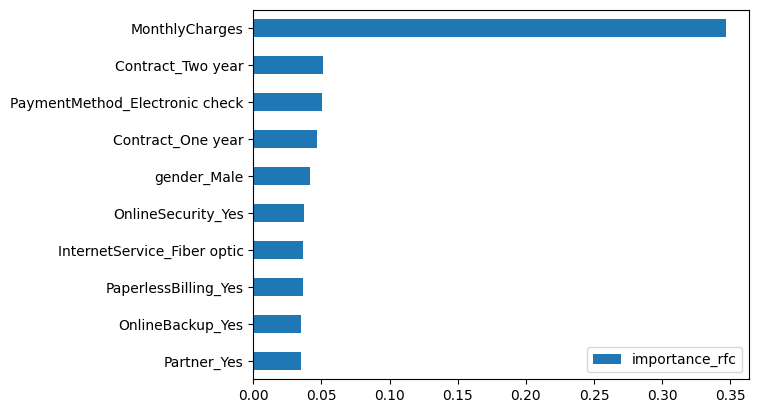

In [16]:
from sklearn.ensemble import RandomForestClassifier
from lifelines.utils import concordance_index

rfc = RandomForestClassifier(n_estimators=100, random_state=0)
rfc.fit(X_trn, E_trn)

ci_rfc_trn = concordance_index(T_trn, rfc.predict_proba(X_trn)[:,0], E_trn)
ci_rfc_val = concordance_index(T_val, rfc.predict_proba(X_val)[:,0], E_val)

print(f'Concordance index of Random forest classifier: train: {ci_rfc_trn:.3f} valid: {ci_rfc_val:.3f}')

# feature importance
fi_rfc = rfc.feature_importances_
rfi_rfc =  np.abs(fi_rfc)/np.sum(np.abs(fi_rfc))
lab = X_trn.columns
df_fi_rfc = pd.DataFrame(data={'importance_rfc': rfi_rfc}, index=lab)
df_fi_rfc = df_fi_rfc.sort_values(by='importance_rfc', ascending=True)[-10:]
df_fi_rfc.plot.barh(y='importance_rfc');

In [17]:
df_fi_rfc.sort_values(by='importance_rfc', ascending=False)

,importance_rfc
MonthlyCharges,0.346583
Contract_Two year,0.051150
PaymentMethod_Electronic check,0.050140
Contract_One year,0.046801
gender_Male,0.041857
OnlineSecurity_Yes,0.037556
InternetService_Fiber optic,0.036558
PaperlessBilling_Yes,0.036296
OnlineBackup_Yes,0.035264
Partner_Yes,0.034986


Concordance index of Random forest regressor: train: 0.919 valid: 0.817


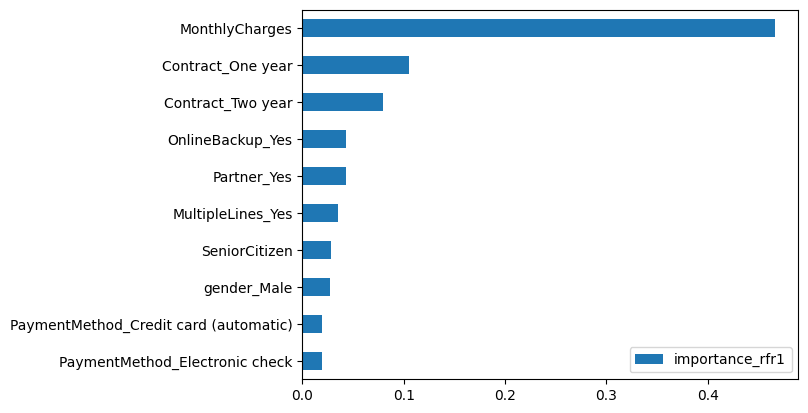

In [18]:
from sklearn.ensemble import RandomForestRegressor

rfr1 = RandomForestRegressor(n_estimators=100, random_state=42)

X_trn1 = X_trn[E_trn == True]
T_trn1 = T_trn[E_trn == True]
E_trn1 = E_trn[E_trn == True]

rfr1.fit(X_trn1, T_trn1)
ci_rfr1_trn = concordance_index(T_trn1, rfr1.predict(X_trn1), E_trn1)
ci_rfr1_val = concordance_index(T_val, rfr1.predict(X_val), E_val)

print(f'Concordance index of Random forest regressor: train: {ci_rfr1_trn:.3f} valid: {ci_rfr1_val:.3f}')

# feature importance
fi_rfr1 = rfr1.feature_importances_
rfi_rfr1 =  np.abs(fi_rfr1)/np.sum(np.abs(fi_rfr1))
lab = X_trn.columns
df_fi_rfr1 = pd.DataFrame(data={'importance_rfr1': rfi_rfr1}, index=lab)
df_fi_rfr1 = df_fi_rfr1.sort_values(by='importance_rfr1', ascending=True)[18:]
df_fi_rfr1.plot.barh(y='importance_rfr1');

In [19]:
df_fi_rfr1.sort_values(by='importance_rfr1', ascending=False)

,importance_rfr1
MonthlyCharges,0.466281
Contract_One year,0.105160
Contract_Two year,0.079135
OnlineBackup_Yes,0.043223
Partner_Yes,0.042977
MultipleLines_Yes,0.035529
SeniorCitizen,0.028447
gender_Male,0.027198
PaymentMethod_Credit card (automatic),0.019719
PaymentMethod_Electronic check,0.019448


Concordance index of Random forest regressor: train: 0.938 valid: 0.820


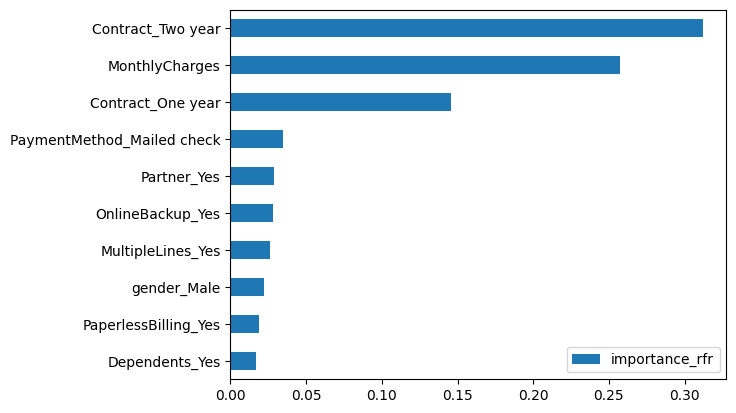

In [20]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(X_trn, T_trn)

ci_rfr_trn = concordance_index(T_trn, rfr.predict(X_trn), E_trn)
ci_rfr_val = concordance_index(T_val, rfr.predict(X_val), E_val)

print(f'Concordance index of Random forest regressor: train: {ci_rfr_trn:.3f} valid: {ci_rfr_val:.3f}')

# feature importance
fi_rfr = rfr.feature_importances_
rfi_rfr =  np.abs(fi_rfr)/np.sum(np.abs(fi_rfr))
lab = X_trn.columns
df_fi_rfr = pd.DataFrame(data={'importance_rfr': rfi_rfr}, index=lab)
df_fi_rfr = df_fi_rfr.sort_values(by='importance_rfr', ascending=True)[18:]
df_fi_rfr.plot.barh(y='importance_rfr');

In [21]:
df_fi_rfr.sort_values(by='importance_rfr', ascending=False)

,importance_rfr
Contract_Two year,0.312050
MonthlyCharges,0.257313
Contract_One year,0.145683
PaymentMethod_Mailed check,0.034982
Partner_Yes,0.028924
OnlineBackup_Yes,0.027996
MultipleLines_Yes,0.025800
gender_Male,0.022176
PaperlessBilling_Yes,0.019041
Dependents_Yes,0.016708


In [22]:
rfc = RandomForestClassifier(n_estimators=100, random_state=0)
rfc.fit(X_trn, E_trn)

# add to X_val the predicted event
X_val_plus_E = X_val.copy()
X_val_plus_E[event_col] = rfc.predict(X_val)

# for the training dataset add the event column
feat_plus_E = np.union1d(features, [event_col])
X_trn_plus_E = data_train[feat_plus_E]
X_val_plus_E = X_val_plus_E[X_trn_plus_E.columns]


rfr = RandomForestRegressor(n_estimators=100, random_state=0)
rfr.fit(X_trn_plus_E, T_trn)

ci_rfcr_trn = concordance_index(T_trn, rfr.predict(X_trn_plus_E), E_trn)
ci_rfcr_val = concordance_index(T_val, rfr.predict(X_val_plus_E), E_val)

print(f'Concordance index of Random forest classifier-regressor: train: {ci_rfcr_trn:.3f}, valid: {ci_rfcr_val:.3f}')

Concordance index of Random forest classifier-regressor: train: 0.957, valid: 0.818


In [23]:
rfr = RandomForestRegressor(n_estimators=100, random_state=0)
rfr.fit(X_trn, T_trn)

# add to X_val the predicted time
X_val_plus_T = X_val.copy()
X_val_plus_T[time_col] = rfr.predict(X_val)

# for the training dataset add the time column
feat_plus_T = np.union1d(features, [time_col])
X_trn_plus_T = data_train[feat_plus_T]

rfc = RandomForestClassifier(n_estimators=100, random_state=0)
rfc.fit(X_trn_plus_T, E_trn)

ci_rfrc_trn = concordance_index(T_trn, ~rfc.predict(X_trn_plus_T), E_trn)
ci_rfrc_val = concordance_index(T_val, ~rfc.predict(X_val_plus_T), E_val)
print(f'Concordance index of Random forest regressor-classifier: train: {ci_rfrc_trn:.3f}, valid: {ci_rfrc_val:.3f}')

Concordance index of Random forest regressor-classifier: train: 0.904, valid: 0.622


In [24]:
!pip install catboost


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 6.8 MB/s eta 0:00:00


Concordance index of CatBoost regressor: train: 0.863 valid: 0.832


,importance_cbr
Contract_Two year,0.390560
Contract_One year,0.158429
MonthlyCharges,0.109617
PaymentMethod_Mailed check,0.043039
Partner_Yes,0.042317
MultipleLines_Yes,0.041489
OnlineBackup_Yes,0.040717
PaymentMethod_Electronic check,0.024401
OnlineSecurity_Yes,0.019440
Dependents_Yes,0.018578


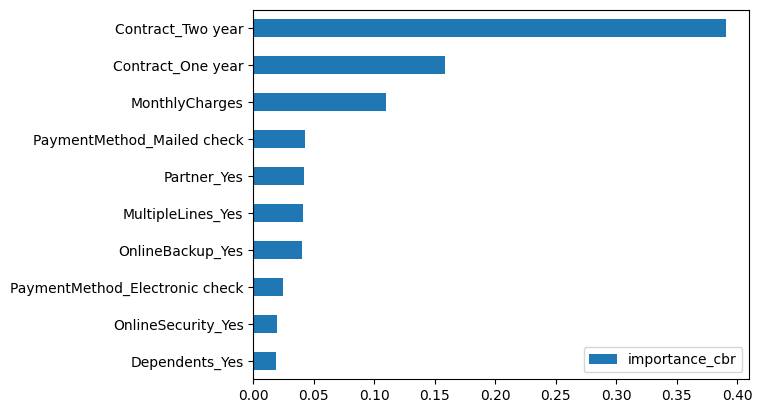

In [25]:
from catboost import CatBoostRegressor

# Create the CatBoostRegressor model
cbr = CatBoostRegressor(n_estimators=100, random_seed=42, verbose=0)
cbr.fit(X_trn, T_trn)

ci_cbr_trn = concordance_index(T_trn, cbr.predict(X_trn), E_trn)
ci_cbr_val = concordance_index(T_val, cbr.predict(X_val), E_val)

print(f'Concordance index of CatBoost regressor: train: {ci_cbr_trn:.3f} valid: {ci_cbr_val:.3f}')

# feature importance
fi_cbr = cbr.get_feature_importance()
rfi_cbr = np.abs(fi_cbr) / np.sum(np.abs(fi_cbr))
lab = X_trn.columns
df_fi_cbr = pd.DataFrame(data={'importance_cbr': rfi_cbr}, index=lab)
df_fi_cbr = df_fi_cbr.sort_values(by='importance_cbr', ascending=True)[18:]
df_fi_cbr.plot.barh(y='importance_cbr')
df_fi_cbr.sort_values(by='importance_cbr', ascending=False)


Accuracy of AdaBoost classifier: train: 0.999 valid: 0.998


,importance_abc
MonthlyCharges,0.76
StreamingTV_Yes,0.06
StreamingMovies_Yes,0.04
PaymentMethod_Mailed check,0.02
Partner_Yes,0.02
PaymentMethod_Credit card (automatic),0.02
gender_Male,0.02
Dependents_Yes,0.01
PaymentMethod_Electronic check,0.01
MultipleLines_Yes,0.01


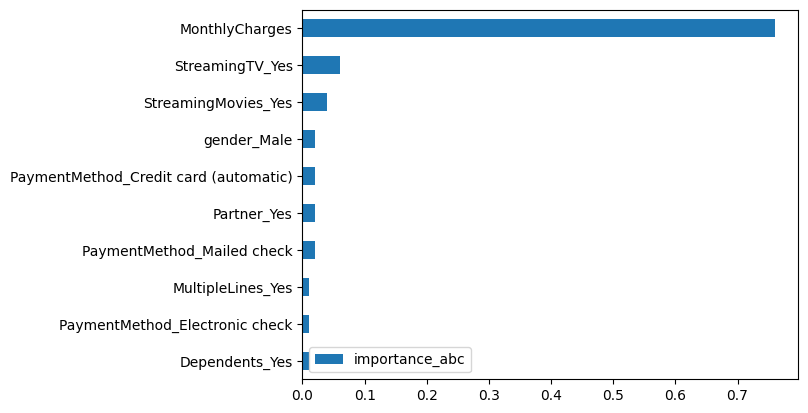

In [26]:
from sklearn.ensemble import AdaBoostClassifier

# Convert your target variable T_trn and T_val to classes
# For example, convert it into binary classes (0 or 1) based on a threshold
threshold = 0.5
T_trn_classes = (T_trn > threshold).astype(int)
T_val_classes = (T_val > threshold).astype(int)

# Create the AdaBoostClassifier model
abc = AdaBoostClassifier(n_estimators=100, random_state=42)
abc.fit(X_trn, T_trn_classes)

# Calculate accuracy or other classification metric
from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(T_trn_classes, abc.predict(X_trn))
accuracy_valid = accuracy_score(T_val_classes, abc.predict(X_val))

print(f'Accuracy of AdaBoost classifier: train: {accuracy_train:.3f} valid: {accuracy_valid:.3f}')

# Feature importance
fi_abc = abc.feature_importances_
rfi_abc = np.abs(fi_abc) / np.sum(np.abs(fi_abc))
lab = X_trn.columns
df_fi_abc = pd.DataFrame(data={'importance_abc': rfi_abc}, index=lab)
df_fi_abc = df_fi_abc.sort_values(by='importance_abc', ascending=True)[18:]
df_fi_abc.plot.barh(y='importance_abc')
df_fi_abc.sort_values(by='importance_abc', ascending=False)


In [27]:
# choose 20 random seeds
np.random.seed(0)
seeds = np.random.permutation(1000)[:20]

In [28]:
rfc_ci = []
rfr1_ci = []
rfr2_ci = []

for _seed in seeds:
  index_train, index_test = train_test_split( range(N), test_size = 0.3, random_state=_seed)
  data_train = churn_data.loc[index_train].reset_index(drop=True)
  data_test  = churn_data.loc[index_test].reset_index(drop=True)

  # Creating the X, T and E inputs
  X_trn, X_val = data_train[features], data_test[features]
  T_trn, T_val = data_train[time_col], data_test[time_col]
  E_trn, E_val = data_train[event_col], data_test[event_col]

  rfc = RandomForestClassifier(n_estimators=100, random_state=42)
  rfc.fit(X_trn, E_trn)
  rfc_ci.append(concordance_index(T_val, rfc.predict_proba(X_val)[:,0], E_val))

  rfr1 = RandomForestRegressor(n_estimators=100, random_state=42)
  X_trn1 = X_trn[E_trn == True]
  T_trn1 = T_trn[E_trn == True]
  E_trn1 = E_trn[E_trn == True]
  rfr1.fit(X_trn1, T_trn1)
  rfr1_ci.append(concordance_index(T_val, rfr1.predict(X_val), E_val))

  rfr2 = RandomForestRegressor(n_estimators=100, random_state=42)
  rfr2.fit(X_trn, T_trn)
  rfr2_ci.append(concordance_index(T_val, rfr2.predict(X_val), E_val))

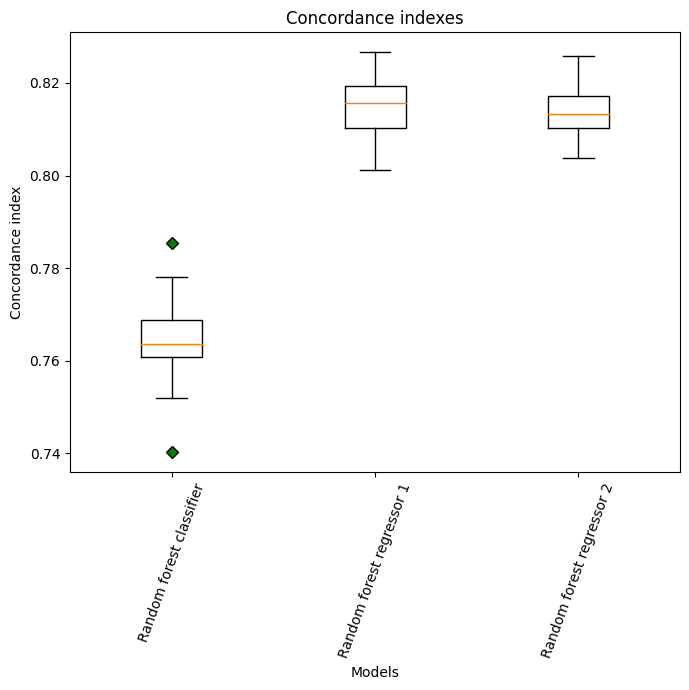

In [29]:
data = [rfc_ci, rfr1_ci, rfr2_ci, ]
green_diamond = dict(markerfacecolor='g', marker='D')

fig1, ax1 = plt.subplots(figsize=(7,7))
ax1.set_title('Concordance indexes')
ax1.boxplot(data, notch=False, flierprops=green_diamond)
ax1.set_xticklabels(['Random forest classifier', 'Random forest regressor 1', 'Random forest regressor 2'], rotation=70)
ax1.set_xlabel('Models')
ax1.set_ylabel('Concordance index')
plt.tight_layout()
plt.savefig('concordance.png', format='png', dpi=100)
# plt.show()